<a href="https://colab.research.google.com/github/guthi1/reinforcement-learning/blob/main/Assignment_3/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 -- Policy Gradients
## Instructions:
* This is an individual assignment. You are not allowed to discuss the problems with other students.
* Part of this assignment will be autograded by gradescope. You can use it as immediate feedback to improve your answers. You can resubmit as many times as you want.
* All your solution, code, analysis, graphs, explanations should be done in this same notebook.
* Please make sure to execute all the cells before you submit the notebook to the gradescope. You will not get points for the plots if they are not generated already.
* If you have questions regarding the assignment, you can ask for clarifications in Piazza. You should use the corresponding tag for this assignment.

This assignment has 4 parts. The goals of these parts are:
- **Part 1**: Implementing a parameterized (neural network) policy with PyTorch
- **Part 2**: Understanding the REINFORCE algorithm
- **Part 3**: Extending the REINFORCE algorithm with a baseline
- **Part 4**: Understanding Actor-Critic


### Loading Dependencies

In [1]:
!pip install otter-grader
!pip install gym[classic_control]
!git clone https://github.com/chandar-lab/INF8250e-assignments-public.git public

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 168 kB 4.7 MB/s 
     |████████████████████████████████| 297 kB 31.2 MB/s 
     |████████████████████████████████| 98 kB 4.0 MB/s 
     |████████████████████████████████| 1.6 MB 47.5 MB/s 
     |████████████████████████████████| 46 kB 2.0 MB/s 
     |████████████████████████████████| 84 kB 561 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 2.6 MB/s 
Cloning into 'public'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 132 (delta 85), reused 111 (delta 70), pack-reused 0
Receiving objects: 100% (132/132), 876.31 KiB | 7.55 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [2]:
import otter
grader = otter.Notebook(colab=True, tests_dir='./public/assignment_3_python/tests')

In [3]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.distributions as torchdist
import torch.nn as nn
import torch.nn.functional as F
import warnings
import functools
import os

from IPython import display

from gym.envs.classic_control import CartPoleEnv
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [4]:
GRADESCOPE_ENV_VAR = "RUNNING_IN_GRADESCOPE"

def running_in_gradescope():
    var = os.getenv(GRADESCOPE_ENV_VAR)
    if var is None:
        return False
    return var == 'yes'

## The Environment

For this assignment, we will use  `CartPole-v0` from OpenAI Gym. In this environment, the goal is to balance an inverted pendulum on a cart by moving the cart laterally. The state of the agent has four components:

- The horizontal position of the cart, $x$
- The velocity of the cart, $\dot{x}$
- The angle of the pendulum, measured relative to the vertical axis, $\theta$
- The angular velocity of the pendulum, $\dot\theta$

There are two actions, which apply leftward and rightward force to the cart.

The agent receives a reward of $1$ at each timestep,and the episode ends when the pendulum drops too far ($|\theta|$ gets large, around $\pi/2$ radians) or when the cart goes out of bounds. Also, the environment terminates after 200 steps if it hasn't already terminated, so the greatest possible return is $200$.

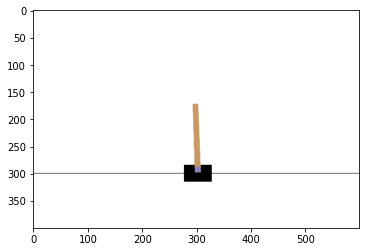

In [5]:
env = gym.make('CartPole-v0')
env.reset()
cartpole_img = env.render(mode='rgb_array')
plt.imshow(cartpole_img)
env.close()

# Part 1. Parameterized Policy (30 pts total)

In this assignment, we will be studying Policy Gradient algorithms. In these algorithms, rather than using action-values to select actions, the policy itself is parameterized (in our case, by a neural network), and the policy is optimized directly via gradient ascent.

We will use a neural network to represent the policy here. The input to the neural network is a state, and the output should somehow encode a probability distribution over the action space. Our environment has a discrete action space, so the policy should output parameters for a *Categorical distribution*.



## 1a: The Policy Network (5 pts)
As a first step, fill in the `policy_init_network` function, which should return a torch neural net that will be to produce policy distributions for input states. You are free to experiment with different neural network architectures if you desire, but we recommend the following. Using `torch.nn.Sequential`, make a multilayer perceptron (MLP) with the following layers:

1. A linear layer of size `(state space dimension, 32)`, followed by a ReLU activation
1. A linear layer of size `(32, 32)`, followed by a ReLU activation
1. A linear layer of size `(32, number of actions)` followed by a Softmax activation, to make a probability distribution over actions.

In [6]:
from torch.nn.modules.activation import Softmax
def policy_init_network(env: gym.Env) -> nn.Module:
    # ---------------------------------
    return nn.Sequential(
        nn.Linear(env.observation_space.shape[0], 32),
        nn.ReLU(),
        nn.Linear(32,32),
        nn.ReLU(),
        nn.Linear(32, env.action_space.n),
        nn.Softmax()
    )
    # ---------------------------------

In [7]:
grader.check("question 1a")

question 1a results: All test cases passed!

## 1b: The Policy Class (15 pts)
In this part, we will build a class to represent the parameterized policy. This will be done in a few steps.

### Part I: The constructor
In the constructor of the `Policy` class, initialize the variable `opt`, which will be used to optimize the policy parameters. This variable should be a `torch.optim.Optimizer`.

### Part II: The policy distribution
Fill in the `dist` method. This method takes as input a state and outputs a torch [`Distribution`](https://pytorch.org/docs/stable/distributions.html) over actions.

### Part III: Sampling actions
Fill in the `action` method. This method samples a random action from the policy at a given state.

In [321]:
class Policy:
  def __init__(self,
               env: gym.Env,
               network: nn.Module,
               discount=0.99,
               name="Abstract Policy"):
    self.name = name
    self.network = network
    self.discount = discount

    self.env = env
    self.obs_dim = env.observation_space.shape[0]
    self.n_actions = env.action_space.n

    # Your code here  (Part I)
    # ==========================
    self.opt = torch.optim.Adam(network.parameters())
    # ==========================

  """
  Get the distribution over actions for a given state
  """
  def dist(self, x: np.ndarray) -> torchdist.distribution.Distribution:
    dist = None
    # Your code here (Part II)
    # ========================
    X = torch.from_numpy(x)
    if len(x.shape) == 1:
        X = X.unsqueeze(0)
    probs = self.network.forward(X)
    dist = torch.distributions.Categorical(probs)
    self.m = dist
    # ========================
    return dist

  """
  Sample a random action from the policy at a given state

  Input: a state encoded as a numpy array
  Output: an action encoded as an int
  """
  def action(self, x: np.ndarray) -> int:
    action = None
    # Your code here (Part III)
    # ========================
    action = int(self.dist(x).sample())
    # ========================
    return action

  def update(self, states, actions, rewards, dones) -> float:
    raise NotImplementedError


In [252]:
grader.check("question 1b")

question 1b results: All test cases passed!

## 1c: Generating Rollouts (10 pts)

Now, fill in the following function that rolls out $N$ episodes in the environment with the policy. The function should return `(states, actions, rewards, dones)` where

1. `states` is a record of the states observed over the course of the episodes.
1. `actions` is a record of the actions taken.
1. `rewards` is a record of the rewards earned.
1. `dones` is an array of `bool`s that marks where the episodes end. For example, if each episode is 3 steps long, `dones = [False, False, True, False, False, True,...]`.

In [221]:
def show_state(env, step=0, info=""):
    """ From: https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server """
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title(f"{env.spec.id} | Step: {step} {info}")
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [283]:
def rollout(env: gym.Env, policy: Policy, N=1, render=False):
    states = []
    actions = []
    rewards = []
    dones = []
    # Your code here
    #==========================
    for episode in range(N):
        state = env.reset()
        states.append(state)
        done = False
        step = 0
        
        while not done:
            action = policy.action(state)
            state, reward, done, _ = env.step(action)

            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            if not done:
                states.append(state)

            if render:
                show_state(env.unwrapped, step=step)

            step += 1
    #==========================
    if render:
        env.close()
    return (np.array(states), np.array(actions), np.array(rewards), np.array(dones))

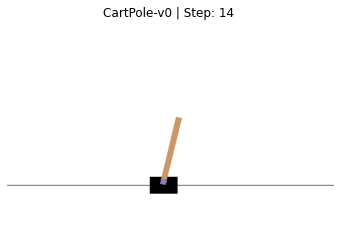

(array([[ 0.02230983,  0.01509999,  0.02543105, -0.01961452],
       [ 0.02261183,  0.20984817,  0.02503875, -0.3041664 ],
       [ 0.02680879,  0.0143785 ,  0.01895543, -0.0036932 ],
       [ 0.02709636,  0.20922355,  0.01888156, -0.29033569],
       [ 0.03128083,  0.01383752,  0.01307485,  0.00824195],
       [ 0.03155758, -0.18146947,  0.01323969,  0.30502132],
       [ 0.02792819, -0.3767776 ,  0.01934011,  0.60185015],
       [ 0.02039264, -0.57216465,  0.03137712,  0.9005616 ],
       [ 0.00894935, -0.7676974 ,  0.04938835,  1.2029396 ],
       [-0.0064046 , -0.9634219 ,  0.07344714,  1.5106827 ],
       [-0.02567304, -0.7692626 ,  0.10366079,  1.241803  ],
       [-0.04105829, -0.5756127 ,  0.12849686,  0.98330915],
       [-0.05257054, -0.7722002 ,  0.14816304,  1.3134335 ],
       [-0.06801455, -0.96885407,  0.17443171,  1.6485832 ],
       [-0.08739163, -0.7761478 ,  0.20740338,  1.4149334 ]],
      dtype=float32), array([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]), array([

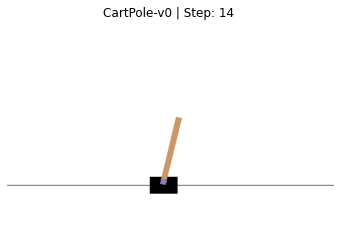

In [285]:
if __name__ == "__main__":
    test_env = gym.make('CartPole-v0')
    test_policy = Policy(test_env, policy_init_network(test_env), 0.99)
    num_rollouts = 1
    test_s, test_a, test_r, test_d = rollout(test_env, test_policy, num_rollouts, True)
    print(rollout(test_env, test_policy, num_rollouts, True))

In [281]:
grader.check("question 1c")

question 1c results: All test cases passed!

# 2. REINFORCE (47 pts total)
In this section, we will implement the REINFORCE algorithm.

<!-- BEGIN QUESTION -->


## 2a: Discounting Rewards (22 pts total)

This problem has 3 parts.

Recall the form of the REINFORCE policy gradient:

$$
\nabla_\theta J(\theta) = \sum_{k=0}^T\mathbf{E}\left\{G^{\pi_\theta}\nabla_\theta\log\pi_\theta(a_k\mid s_k)\right\}
$$

Here $\pi_\theta$ is the parameterized (neural net) policy with parameters $\theta$, and $G^{\pi_\theta}$ is the random variable corresponding to the discounted return induced by following $\pi_\theta$. Note that at timestep $k$, action $a_k$ had no influence on rewards incurred before timestep $k$. For this reason, it is generally preferred to compute the following,

$$
\widehat\nabla_\theta J(\theta) = \sum_{k=0}^T\mathbf{E}\left\{G^{\pi_\theta}_k\nabla_\theta\log\pi_\theta(a_k\mid s_k)\right\}
$$

where

$$
G^{\pi_\theta}_k = \sum_{t=k}^T\gamma^{t-k}r(s_k, a_k)
$$

### Part I (5 pts):
**Question**: Why do you think it is preferred to substitute $\nabla_\theta J(\theta)$ for $\widehat\nabla_\theta J(\theta)$ in policy gradient algorithms?

It is preferable to use the unbiased version of the equation so as not to impact the previous actions. You can make 10 great moves and miss the 11th, it doesn't mean that the first moves were not good

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Part II (5 points):

It may help to make the assumption that at the end of an episode, the agent keeps receiving the final reward indefinitely. So, when an episode ends at time $T$, the "effective reward" at that last timestep is

$$
r_T = r(s_T, a_T) + \gamma r(s_T, a_T) + \gamma^2r(s_T, a_T) + \dots\\
= r(s_T, a_T)\left(\sum_{k=0}^\infty\gamma^k\right) 
$$

It's like as if the agent remains in its terminal state forever. When computing the discounted return of a trajectory, you may replace the terminal reward with this "effective reward". We will call this "the perpetuity trick".

**Question**: When should one apply the "perpetuity trick", and what effect would you expect it to have on training?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Part III (12 points):
Implement the function `discounted_returns`, which computes the values $(G_1^{\pi_\theta},G_2^{\pi_\theta},\dots)$ for a given sequence of rewards.

The function takes three arguments:

1. `rewards`: An array of rewards, which may have been collected over several trajectories. 
1. `dones`: An array of `bool`s, which mark where trajectories ended.
1. `discount`: The discount factor.
1. `perpetuity`: A boolean that indicates whether or not the perpetuity trick should be used.

The output of the function should be a list of the same length as `rewards` containing the cumulative discounted future returns starting at each step in the reward sequence. Mathematically, for some index $k$, if $T$ is the first index after $k$ for which `dones[T] = True`, then

$$
\texttt{returns}[k] = \texttt{rewards}[k] + \gamma\texttt{rewards}[k+1] + \dots + \gamma^{T-k}\texttt{rewards}[T]\quad \text{(+ perpetuity, if applicable)}
$$

For example, suppose we gather data from two trajectories, which had rewards `[1,2,3]` and `[4, 2, 1]` respectively. Then:

- `rewards = [1,2,3,4,2,1]`
- `dones = [False, False, True, False, False, True]`

For `discount = 0.5`, the output should be 

- Without perpetuity trick: `[2.75, 3.5, 3, 5.25, 2.5, 1]`.
- With perpetuity trick: `[3.5, 5, 6, 5.5, 3, 2]`.

**NOTE**: The output should be a numpy array.

In [224]:
def discounted_returns(rewards: np.ndarray, dones: np.ndarray, discount:float, perpetuity = False) -> np.ndarray:
    # Your code here
    # ===============================
    if type(dones) == list:
        #/!\ Problem with the grader, dones is a list
        dones = np.array(dones) 

    returns = list()
    for k, reward in enumerate(rewards):
        # Find next end of episode
        T = k + np.where(dones[k:]==True)[0][0] + 1

        # Calcul perpetuity
        per = lambda k: sum([discount**(k+i) * rewards[T-1] for i in range(1000)]) if perpetuity else 0
        
        # Sum discounted rewards
        r = sum([discount**k * reward for k, reward in enumerate(rewards[k:T])]) + per(len(rewards[k:T]))

        # Save value for current state
        returns.append(r)
    # ===============================
    return np.array(returns)

In [225]:
grader.check("question 2a.3")

question 2a.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

## 2b: The REINFORCE Update (10 pts)
Finally, we'll implement REINFORCE. Fill in the `update` method for the `REINFORCEPolicy` class below. This method takes the following inputs:

1. `states`: An array of observed states over the course of $N$ episodes.
1. `actions`: An array of actions taken at the corresponding `states`.
1. `rewards`: An array of rewards received, where `rewards[k]` is the reward for taking actions `actions[k]` at state `states[k]`.
1. `dones`: An array of `bool`s marking the end of episodes.

This method should perform the following:
- Compute the average policy gradient "loss", which is $-\sum_{n=1}^{T}G_n^{\pi_\theta}\log\pi_\theta(a_n\mid s_n)$,  averaged over all trajectories
- Compute the policy gradient
- Update the policy parameters

The method should return a dictionary that contains information from the update. For now, the dictionary should only have one entry with key `'policy_loss'` that contains a scalar loss from the policy gradient computation.

In [286]:
    ## Matrix calcul
    # self.network.train()
    # self.opt.zero_grad()
    # d_returns = discounted_returns(rewards, dones, self.discount)

    # # Find log prob of actions
    # actions_tensor = torch.Tensor(actions)
    # m = self.dist(states)
    # log_proba = m.log_prob(actions_tensor)

    # # Sum
    # loss = -torch.sum(torch.FloatTensor(d_returns) * log_proba)

    # # Do update
    # loss.backward()
    # self.opt.step()

    # loss_dict["policy_loss"] = float(loss)

    # self.network.eval()

In [328]:
class REINFORCEPolicy(Policy):
  def __init__(self,
               env: gym.Env,
               network: nn.Module,
               discount=0.99,
               name="Plain REINFORCE"):
    super().__init__(env, network, discount=discount, name=name)
    
  """
  Perform a gradient update
  Inputs:
    states, actions, rewards, dones: Output from rollout method
  Returns:
    Dictionary with the following keys:
    - "policy_loss": float of the policy gradient loss (the quantity whose gradient is taken)
  """  
  def update(self, states, actions, rewards, dones) -> float:
    loss_dict = {}
    # Your code here
    # ======================
    # d_returns = discounted_returns(rewards, dones, self.discount)

    # n_eps = np.sum(dones)
    # loss = torch.zeros(n_eps)
    # current_loss = []
    # eps = 0

    # for s, a, d_r, d, in zip(states, torch.Tensor(actions), d_returns, dones):
    #     m = self.dist(s)
    #     log_proba = m.log_prob(torch.Tensor(a).unsqueeze(0))
    #     current_loss.append(log_proba * d_r)
    #     if d:
    #         loss[eps] = -torch.cat(current_loss).sum()
    #         current_loss = []
    #         eps += 1

    # # Do update
    # self.opt.zero_grad()
    # loss = loss.mean()
    # loss.backward()
    # self.opt.step()


    # Matrix calcul   
    d_returns = discounted_returns(rewards, dones, self.discount)

    # Find end of episode
    idx_end_eps = np.where(dones[:]==True)[0]
    eps_count = len(idx_end_eps)
    eps = 0
    last_end_eps = 0

    loss = torch.zeros(eps_count)

    # Iterate throw eps
    for end_eps in idx_end_eps:
        # Create episode tensor
        states_eps = states[last_end_eps:end_eps]
        actions_eps = actions[last_end_eps:end_eps]
        d_returns_eps = d_returns[last_end_eps:end_eps]

        # Find log prob of actions
        actions_tensor = torch.Tensor(actions_eps)
        m = self.dist(states_eps)
        log_proba = m.log_prob(actions_tensor)
        # print(log_proba)

        # Find loss
        loss[eps] = -torch.sum(torch.FloatTensor(d_returns_eps) * log_proba)

        # Update eps idx
        last_end_eps = end_eps
        eps += 1

    # Do update
    self.opt.zero_grad()
    loss = loss = loss.mean()
    loss.backward()
    self.opt.step()

    loss_dict["policy_loss"] = float(loss)
    # ======================
    return loss_dict

In [329]:
test_env = gym.make('CartPole-v0')
assert_equal = functools.partial(torch.testing.assert_close, rtol=0, atol=0)
test_reinforce = REINFORCEPolicy(test_env, policy_init_network(test_env), 0.99)
test_states, test_actions, test_rewards, test_dones = rollout(test_env, test_reinforce, 2)

loss = test_reinforce.update(test_states, test_actions, test_rewards, test_dones)
print(loss)
assert_equal(isinstance(loss,dict), True)
assert_equal('policy_loss' in loss, True)

{'policy_loss': 114.34689331054688}


In [330]:
grader.check("question 2b")

question 2b results: All test cases passed!

<!-- END QUESTION -->

## 2c: Experiments (15 pts)

The code below will train agents with REINFORCE using a varying number $N$ of trajectories per gradient estimate, for a fixed number of gradient steps. After each gradient step, we roll out 5 episodes and plot the mean and variance of their returns. Before running the experiments, think about how you expect the performance of the agents to depend on $N$.

N = 1


100%|██████████| 400/400 [01:12<00:00,  5.53it/s]


N = 5


100%|██████████| 400/400 [02:55<00:00,  2.27it/s]


N = 10


100%|██████████| 400/400 [04:50<00:00,  1.37it/s]


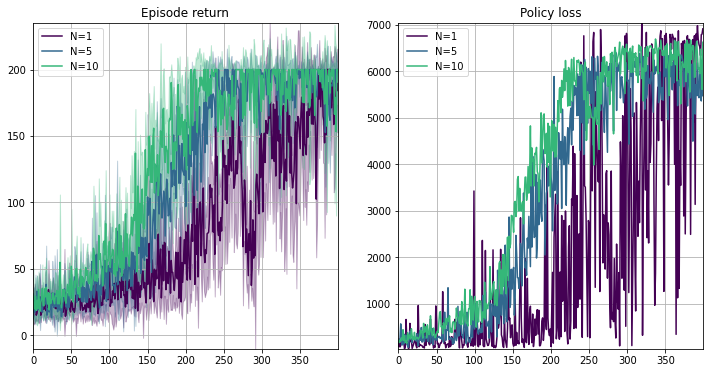

In [332]:
Ns = [1, 5, 10]
# Ns = [1] 

env = gym.make('CartPole-v0')
agents = [
    REINFORCEPolicy(env, policy_init_network(env))
    for _ in Ns
]

gradient_steps = 400
scores = [np.zeros(gradient_steps) for N in Ns]
stds = [np.zeros(gradient_steps) for N in Ns]

test_runs = 5

def rollout_score(env, policy):
  _, _, rewards, _ = rollout(env, policy, N=1)
  return np.sum(rewards)

gs = list(range(gradient_steps))

cmap = plt.get_cmap('viridis')
fig, (ret_ax, loss_ax) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

if not running_in_gradescope():
    for i in range(len(Ns)):
      reinforce_policy = agents[i]
      N = Ns[i]
      print(f"N = {N}")
      losses = []
      for g in tqdm(range(gradient_steps)):
        states, actions, rewards, dones = rollout(env, reinforce_policy, N=N)
        loss = reinforce_policy.update(states, actions, rewards, dones)
        losses.append(loss['policy_loss'])
        res = [rollout_score(env, reinforce_policy) for _ in range(test_runs)]
        scores[i][g] = np.mean(res)
        stds[i][g] = np.std(res)
      color = cmap(i / len(Ns))
      ret_ax.plot(gs, scores[i], label=f"N={N}", color = color)
      ret_ax.fill_between(gs, scores[i] - stds[i], scores[i] + stds[i], alpha=0.3, color=color)
      loss_ax.plot(gs, losses, label=f"N={N}", color = color)
    ret_ax.legend()
    ret_ax.grid(True)
    ret_ax.margins(0)
    ret_ax.set_title('Episode return')
    loss_ax.legend()
    loss_ax.grid(True)
    loss_ax.margins(0)
    loss_ax.set_title("Policy loss")

In [333]:
plt.close('all')

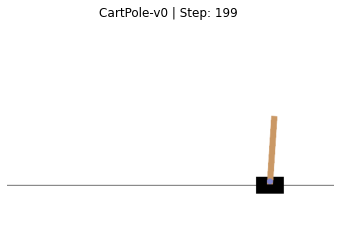

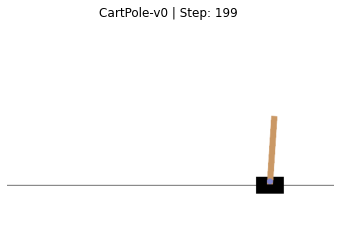

In [335]:
if __name__ == "__main__":
    AGENT = 2

    test_env = gym.make('CartPole-v0')
    test_policy = agents[AGENT]
    num_rollouts = 1
    test_s, test_a, test_r, test_d = rollout(test_env, test_policy, num_rollouts, True)

### Analysis
Based on your results, report how the number of rollout trajectories per update affected the learning process. Do your results match your expectations? Explain why or why not.

# 3. REINFORCE with Baseline (40 pts total)
When using a baseline in REINFORCE, the policy gradient formula is modified to the following,

$$
\nabla_\theta J(\theta) = \sum_{k=0}^T\mathbf{E}\left\{(G^{\pi_\theta} - b(s_k))\nabla_\theta\log\pi_\theta(a_k\mid s_k)\right\}
$$

for some function $b:\mathcal{S}\to\mathbf{R}$.

<!-- BEGIN QUESTION -->

## 3a: Understanding the baseline (12 pts)
1. **(3 pts)** What purpose does the baseline serve?
1. **(3 pts)** If the baseline is a constant (that is, $b(s_1) = b(s_2)$ for any pair of states $(s_1, s_2)$), should we expect the performance of REINFORCE with this baseline to be any different from standard REINFORCE?
1. **(3 pts)** Why can't the baseline be a function of the action as well as the state? 
1. **(3 pts)** Does the inclusion of an arbitrary baseline always help? 

_Type your answer here, replacing this text._

<!-- END QUESTION -->

## 3b: The Value Function (3 pts)
In our experiments, we will use the value function as our baseline. It will be necessary to learn the value function from data, so our baseline will have the form

$$
b(s) = V^{\pi_\theta}_\phi(s)
$$

where $\phi$ denotes the parameters of the value function.

Fill in the code for the construction of the value function neural net in `value_init_network`. The network architecture should be similar to that of the policy network besides the output layer.

In [ ]:
def value_init_network(env: gym.Env) -> nn.Module:
  # Your code here
  # ===========================================================
  ...
  # ===========================================================

In [ ]:
grader.check("question 3b")

<!-- BEGIN QUESTION -->

## 3c: REINFORCE with Baseline (10 pts)

Fill in the constructor and the `update` method for `REINFORCEWithBaselinePolicy`.

The constructor should do set two variables:
* `self.value_network`: the value function neural network
* `self.value_opt`: the `torch.optim.Optimizer` for the value function parameters

This method should perform the following:
- Compute the "policy gradient loss", using the value predictions from the value function network instead of the Monte Carlo return estimates
- Compute the policy gradient, again using the value predictions from the value function network instead of the Monte Carlo return estimates
- Update the policy parameters
- Compute the "value loss", which is mean squared difference between the Monte Carlo return estimates and the value function network predictions at each state in the trajectory
- Update the value function network parameters

As with the standard REINFORCE case, the `update` method returns a dictionary with a key `'policy_loss'` reflecting the loss w.r.t. the policy gradient objective. For `REINFORCEWithBaselinePolicy`'s `update` method, however, the dictionary should also have a key `'value_loss'` reflecting the loss w.r.t. the value function error.

In [ ]:
class REINFORCEWithBaselinePolicy(Policy):
  def __init__(self,
               env: gym.Env,
               policy_network: nn.Module,
               value_network: nn.Module,
               discount=0.99,
               name="REINFORCE with Baseline"):
    super().__init__(env, policy_network, discount=discount, name=name)
    # Your code here
    # ===========================================================
    ...
    # ===========================================================
  
  """
  Perform a gradient update
  Inputs:
    states, actions, rewards, dones: Output from rollout method
  Returns:
    Dictionary with the following keys:
    - "policy_loss": float of the policy gradient loss (the quantity whose gradient is taken)
    - "value_loss": float of the squared TD error
  """  
  def update(self, states, actions, rewards, dones) -> float:
    loss_dict = {}
    # Your code here
    # ======================
    ...
    # ======================
    return loss_dict

In [ ]:
grader.check("question 3c")

<!-- END QUESTION -->

## 3d: Experiments (15 pts)

The code below will train agents with REINFORCE with and without the value function baseline. Think about how you expect the return and loss curves to behave with and without the baseline.

In [ ]:
agents = [
    REINFORCEPolicy(env, policy_init_network(env)),
    REINFORCEWithBaselinePolicy(env, policy_init_network(env), value_init_network(env))
]

gradient_steps = 400
scores = [np.zeros(gradient_steps) for _ in agents]
stds = [np.zeros(gradient_steps) for _ in agents]

test_runs = 5

def rollout_score(env, policy):
  _, _, rewards, _ = rollout(env, policy, N=1)
  return np.sum(rewards)

gs = list(range(gradient_steps))

cmap = plt.get_cmap('viridis')
fig, (ret_ax, loss_ax, value_ax) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

value_losses = []

if not running_in_gradescope():
    for i in range(len(agents)):
      reinforce_policy = agents[i]
      print(f"Training {reinforce_policy.name}")
      losses = []
      for g in tqdm(range(gradient_steps)):
        states, actions, rewards, dones = rollout(env, reinforce_policy, N=1)
        loss = reinforce_policy.update(states, actions, rewards, dones)
        losses.append(loss['policy_loss'])
        if 'value_loss' in loss.keys():
          value_losses.append(loss['value_loss'])
        res = [rollout_score(env, reinforce_policy) for _ in range(test_runs)]
        scores[i][g] = np.mean(res)
        stds[i][g] = np.std(res)
      color = cmap(i / len(agents))
      ret_ax.plot(gs, scores[i], label=reinforce_policy.name, color = color)
      ret_ax.fill_between(gs, scores[i] - stds[i], scores[i] + stds[i], alpha=0.3, color=color)
      loss_ax.plot(gs, losses, label=reinforce_policy.name, color = color)
    ret_ax.legend()
    ret_ax.grid(True)
    ret_ax.margins(0)
    ret_ax.set_title('Episode return')
    loss_ax.legend()
    loss_ax.grid(True)
    loss_ax.margins(0)
    loss_ax.set_title("Policy loss")
    value_ax.plot(gs, value_losses, color = color)
    value_ax.grid(True)
    value_ax.margins(0)
    value_ax.set_title("Value loss")

In [ ]:
plt.close('all')

### Analysis
In your experiments, how did the use of the value function baseline affect your results? Explain the results you observed.

# 4. Actor-Critic (50 pts total)

Finally, we will experiment with an *actor-critic* algorithm. Recall that the gradient rule for REINFORCE with the value function baseline has the following form,

$$
\nabla_\theta J(\theta) = \sum_{k=0}^T\mathbf{E}\left\{(G^{\pi_\theta} - V^{\pi_\theta}_\phi(s_k))\nabla_\theta\log\pi_\theta(a_k\mid s_k)\right\}
$$

Note that

$$
\mathbf{E}\left\{G^{\pi_\theta}\mid s_0 = s\right\} = \mathbf{E}_{a\sim\pi(\cdot\mid s),s'\sim P(\cdot\mid s, a)}\left\{r(s, a) + \gamma V^{\pi_\theta}(s')\right\}
$$

Because of this, actor-critic algorithms estimate $G^{\pi_\theta}$ by $r(s, a) + \gamma V^{\pi_\theta}(s')$. Thus, we can compute one gradient *per environment step*, since we no longer need data from the entire trajectory to estimate $G^{\pi_\theta}$. The gradient rule for the policy network (actor) is

$$
\nabla_\theta J_{\text{actor}}(\theta) = \mathbf{E}\left\{(r_k + \gamma V^{\pi_\theta}_\phi(s_{k+1}) - V^{\pi_\theta}_\phi(s_k))\nabla_\theta\log\pi_\theta(a_k\mid s_k)\right\}
$$

for the policy parameters. The value network (critic) is trained to minimize the mean squared TD error:

$$
\nabla_\phi J_{\text{critic}}(\phi) = \frac{1}{2}\left(V^{\pi_\theta}_\phi(s_k) - \texttt{stop_gradient}\left(r_k + \gamma V^{\pi_\theta}_\phi(s_{k+1})\right)\right)^2
$$

where $\texttt{stop_gradient}$ enforces that no gradients flow through its argument.

## 4a: Understanding Actor-Critic (15 pts total)

This question is split into three conceptual questions.

<!-- BEGIN QUESTION -->

### Part I: Bias in Actor-Critic (5 pts)
It is said that actor-critic policy gradients are more biased than REINFORCE policy gradients. Explain what this means. Are actor-critic policy gradients more biased than REINFORCE policy gradients computed with the value function baseline?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Part II: Per-Step Updates (5 pts)
Even though actor-critic algorithms can perform one update per step, the gradients are computed based on data from only one state transition as opposed to REINFORCE gradients which are averaged over $T$ state transitions. What is the benefit of updating once per environment step?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Part III: Lifelong Learning (5 pts)
Imagine a scenario where an RL agent is to be deployed on a strange planet that we do not know how to simulate. Once we drop the robot on this planet, we can never interact with it again: it just autonomously learns from environment interactions for the rest of its life. Would you prefer to employ Actor-Critic or REINFORCE with baseline for this problem? Why?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 4b: Implementing Actor-Critic (20 pts)
Fill out the `ActorCriticPolicy` class below, according to the guidelines in the code. The `policy_init_network` and `value_init_network` methods will be used to instantiate the neural nets for the actor-critic, however they are trained differently in the actor-critic algorithm.

Rather than implementing an `update` method for actor-critic, we will implement a method `train_episode` which rolls out an episode, performing updates at each step. More precisely, `train_episode` should do the following:

1. Reset the environment to a starting state
1. For each environment step:
    1. Choose an action
    1. Perform an environment step with the chosen action, observing the next state, reward, and terminal signal
    1. Update both the actor and critic networks based on this transition
1. Return a dictionary with the same entries as `REINFORCEWithBaselinePolicy`'s `update` method.

In [ ]:
class ActorCriticPolicy(Policy):
  def __init__(self,
               env: gym.Env,
               policy_network: nn.Module,
               value_network: nn.Module,
               discount=0.99,
               name="Actor-Critic"):
    super().__init__(env, policy_network, discount=discount, name=name)
    # Your code here
    # Initialize self.value_network and self.value_opt like before
    # ===========================================================
    ...
    # ===========================================================
  
  """
  Run a training episode
  Inputs:
    states, actions, rewards, dones: Output from rollout method
  Returns:
    Dictionary with the following keys:
    - "policy_loss": float of the policy gradient loss (the quantity whose gradient is taken),
                     averaged over the episode
    - "value_loss": float of the squared TD error averaged over the episode
  """  
  def train_episode(self) -> float:
    loss_dict = {}
    # Your code here
    # ======================
    ...
    # ======================
    return loss_dict

In [ ]:
grader.check("question 4b")

<!-- END QUESTION -->

## 4c: Experiments (15 pts)

In the following experiments, we test the following agents:

- REINFORCE with one trajectory per gradient update
- REINFORCE with the value function baseline, one trajectory per gradient update
- Actor-Critic

Each agent is trained for 400 episodes, and the experiment is repeated 6 times with different random seeds. The plot displays the mean and variance of the return across the seeds for each agent.

In [ ]:
import itertools
SEEDS = [4, 8, 15, 16, 23, 42]

episodes = 400
eval_runs = 5
eval_every = 5
epochs = list(range(0, episodes, eval_every))

cmap = plt.get_cmap('viridis')
plt.grid(True)
plt.margins(0)
plt.xlabel("Episode")
plt.ylabel("Return")

pg_constructor = lambda: REINFORCEPolicy(env, policy_init_network(env))
pg_baseline_constructor = lambda: REINFORCEWithBaselinePolicy(env, policy_init_network(env), value_init_network(env))

ac_agent_constructor = lambda: ActorCriticPolicy(env, policy_init_network(env), value_init_network(env))

if not running_in_gradescope():
    ### ACTOR CRITIC
    ac_agents = {}
    ac_score_traces = {}
    print(f"Training Actor-Critic")
    for (seed, ep) in tqdm(itertools.product(SEEDS, np.arange(episodes))):
        if seed not in ac_agents.keys():
            np.random.seed(seed)
            torch.manual_seed(seed)
            ac_agents[seed] = ac_agent_constructor()
            ac_score_traces[seed] = []
            ac_agents[seed].env.seed(seed)
        agent = ac_agents[seed]
        loss = agent.train_episode()
        if (ep + 1) % eval_every == 0:
            res = [rollout_score(env, agent) for _ in range(eval_runs)]
            ac_score_traces[seed].append(np.mean(res))

    ac_data = np.vstack([ac_score_traces[seed] for seed in SEEDS])
    ac_score_mean = np.mean(ac_data, axis=0)
    ac_score_std = np.std(ac_data, axis=0)

    plt.plot(epochs, ac_score_mean, color=cmap(0.8), label='Actor Critic')
    plt.fill_between(
        epochs,
        ac_score_mean - ac_score_std,
        ac_score_mean + ac_score_std,
        color=cmap(0.8),
        alpha=0.3
    )

    ### REINFORCE WITH BASELINE
    pg_baseline_agents = {}
    pg_baseline_score_traces = {}
    print(f"Training REINFORCE with Baseline")
    for (seed, ep) in tqdm(itertools.product(SEEDS, np.arange(episodes))):
        if seed not in pg_baseline_agents.keys():
            np.random.seed(seed)
            torch.manual_seed(seed)
            pg_baseline_agents[seed] = pg_baseline_constructor()
            pg_baseline_score_traces[seed] = []
            env.seed(seed)
        agent = pg_baseline_agents[seed]
        states, actions, rewards, dones = rollout(env, agent, N=1)
        loss = agent.update(states, actions, rewards, dones)
        if (ep + 1) % eval_every == 0:
            res = [rollout_score(env, agent) for _ in range(eval_runs)]
            pg_baseline_score_traces[seed].append(np.mean(res))

    pg_baseline_data = np.vstack([pg_baseline_score_traces[seed] for seed in SEEDS])
    pg_baseline_score_mean = np.mean(pg_baseline_data, axis=0)
    pg_baseline_score_std = np.std(pg_baseline_data, axis=0)

    plt.plot(epochs, pg_baseline_score_mean, color=cmap(0.5), label='REINFORCE with Baseline')
    plt.fill_between(
        epochs,
        pg_baseline_score_mean - pg_baseline_score_std,
        pg_baseline_score_mean + pg_baseline_score_std,
        color=cmap(0.5),
        alpha=0.3
    )

    ### REINFORCE
    pg_agents = {}
    pg_score_traces = {}
    print(f"Training REINFORCE with Baseline")
    for (seed, ep) in tqdm(itertools.product(SEEDS, np.arange(episodes))):
        if seed not in pg_agents.keys():
            np.random.seed(seed)
            torch.manual_seed(seed)
            pg_agents[seed] = pg_constructor()
            pg_score_traces[seed] = []
            env.seed(seed)
        agent = pg_agents[seed]
        states, actions, rewards, dones = rollout(env, agent, N=1)
        loss = agent.update(states, actions, rewards, dones)
        if (ep + 1) % eval_every == 0:
            res = [rollout_score(env, agent) for _ in range(eval_runs)]
            pg_score_traces[seed].append(np.mean(res))

    pg_data = np.vstack([pg_score_traces[seed] for seed in SEEDS])
    pg_score_mean = np.mean(pg_data, axis=0)
    pg_score_std = np.std(pg_data, axis=0)

    plt.plot(epochs, pg_score_mean, color=cmap(0.2), label='REINFORCE')
    plt.fill_between(
        epochs,
        pg_score_mean - pg_score_std,
        pg_score_mean + pg_score_std,
        color=cmap(0.2),
        alpha=0.3
    )

    plt.legend()

In [ ]:
plt.close('all')

### Analysis
Based on your experiments, does actor-critic perform favorably to REINFORCE (with and/or without baseline)? Explain your observations. 